# Projeto Final IA

## Introdução
Este projeto tem como objetivo a aplicação de um algoritmo de aprendizado de máquina para predição da quantidade de eletricidade produzida e consumida pelos clientes de energia da Estónia que instalaram painéis solares. O link da competição constando o dataset: https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/overview.

O dataset contém 2M+ de linhas e 9 colunas, sendo elas:
- **county**: identificador do município
- **is_business**: se o cliente é uma empresa ou não
- **product_type**: tipo de contrato adquirido, podendo ser: {0: "combinado", 1: "fixo", 2: "serviço geral": 3: "spot"}
- **target**: o valor de consumo ou produção do segmento relevante da hora. Os segmentos são definidos pelo _município_, _is_business_ e _product_type_.
- **is_consumption**: se o valor é de consumo ou produção
- **datetime**: data e hora da medição
- **data_block_id**: identificador do bloco de dados. Todos os registro com o mesmo _data_block_id_ pertencem ao mesmo bloco de dados disponibilizado.
- **row_id**: identificador da linha
- **prediction_unit_id**: identificador único para cada combinação de _county_, _is_business_ e _product_type_.

### Importando as bibliotecas e dataset

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [141]:
train_df = pd.read_csv("./datasets/train.csv")

train_df

county  is_business  product_type   target  is_consumption  \
0             0            0             1    0.713               0   
1             0            0             1   96.590               1   
2             0            0             2    0.000               0   
3             0            0             2   17.314               1   
4             0            0             3    2.904               0   
...         ...          ...           ...      ...             ...   
2018347      15            1             0  197.233               1   
2018348      15            1             1    0.000               0   
2018349      15            1             1   28.404               1   
2018350      15            1             3    0.000               0   
2018351      15            1             3  196.240               1   

                    datetime  data_block_id   row_id  prediction_unit_id  
0        2021-09-01 00:00:00              0        0                   0  
1        2021-09-01 00:00:00              0        1                   0  
2        2021-09-01 00:00:00              0        2                   1  
3        2021-09-01 00:00:00              0        3                   1  
4        2021-09-01 00:00:00              0        4                   2  
...                      ...            ...      ...                 ...  
2018347  2023-05-31 23:00:00            637  2018347                  64  
2018348  2023-05-31 23:00:00            637  2018348                  59  
2018349  2023-05-31 23:00:00            637  2018349                  59  
2018350  2023-05-31 23:00:00            637  2018350                  60  
2018351  2023-05-31 23:00:00            637  2018351                  60  

[2018352 rows x 9 columns]

In [145]:
train_df[train_df["target"].isna()]

county  is_business  product_type  target  is_consumption  \
178938        0            0             1     NaN               0   
178939        0            0             1     NaN               1   
178940        0            0             2     NaN               0   
178941        0            0             2     NaN               1   
178942        0            0             3     NaN               0   
...         ...          ...           ...     ...             ...   
1806379      15            1             0     NaN               1   
1806380      15            1             1     NaN               0   
1806381      15            1             1     NaN               1   
1806382      15            1             3     NaN               0   
1806383      15            1             3     NaN               1   

                    datetime  data_block_id   row_id  prediction_unit_id  
178938   2021-10-31 03:00:00             60   178938                   0  
178939   2021-10-31 03:00:00             60   178939                   0  
178940   2021-10-31 03:00:00             60   178940                   1  
178941   2021-10-31 03:00:00             60   178941                   1  
178942   2021-10-31 03:00:00             60   178942                   2  
...                      ...            ...      ...                 ...  
1806379  2023-03-26 03:00:00            571  1806379                  64  
1806380  2023-03-26 03:00:00            571  1806380                  59  
1806381  2023-03-26 03:00:00            571  1806381                  59  
1806382  2023-03-26 03:00:00            571  1806382                  60  
1806383  2023-03-26 03:00:00            571  1806383                  60  

[528 rows x 9 columns]

In [146]:
train_df = train_df.dropna()

In [147]:
df = train_df
df = df.drop(columns=["row_id"])
df.head()

county  is_business  product_type  target  is_consumption  \
0       0            0             1   0.713               0   
1       0            0             1  96.590               1   
2       0            0             2   0.000               0   
3       0            0             2  17.314               1   
4       0            0             3   2.904               0   

              datetime  data_block_id  prediction_unit_id  
0  2021-09-01 00:00:00              0                   0  
1  2021-09-01 00:00:00              0                   0  
2  2021-09-01 00:00:00              0                   1  
3  2021-09-01 00:00:00              0                   1  
4  2021-09-01 00:00:00              0                   2

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2018351
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   prediction_unit_id  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 138.6+ MB


In [149]:
df.describe()

county   is_business  product_type        target  is_consumption  \
count  2.017824e+06  2.017824e+06  2.017824e+06  2.017824e+06       2017824.0   
mean   7.297039e+00  5.368268e-01  1.898927e+00  2.748556e+02             0.5   
std    4.780994e+00  4.986421e-01  1.081766e+00  9.095024e+02             0.5   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             0.0   
25%    3.000000e+00  0.000000e+00  1.000000e+00  3.780000e-01             0.0   
50%    7.000000e+00  1.000000e+00  2.000000e+00  3.113300e+01             0.5   
75%    1.100000e+01  1.000000e+00  3.000000e+00  1.802062e+02             1.0   
max    1.500000e+01  1.000000e+00  3.000000e+00  1.548027e+04             1.0   

       data_block_id  prediction_unit_id  
count   2.017824e+06        2.017824e+06  
mean    3.218754e+02        3.304540e+01  
std     1.826310e+02        1.959062e+01  
min     0.000000e+00        0.000000e+00  
25%     1.660000e+02        1.600000e+01  
50%     3.230000e+02        3.300000e+01  
75%     4.790000e+02        5.000000e+01  
max     6.370000e+02        6.800000e+01

In [150]:
df[:500][["datetime", "is_consumption"]]

datetime  is_consumption
0    2021-09-01 00:00:00               0
1    2021-09-01 00:00:00               1
2    2021-09-01 00:00:00               0
3    2021-09-01 00:00:00               1
4    2021-09-01 00:00:00               0
..                   ...             ...
495  2021-09-01 04:00:00               1
496  2021-09-01 04:00:00               0
497  2021-09-01 04:00:00               1
498  2021-09-01 04:00:00               0
499  2021-09-01 04:00:00               1

[500 rows x 2 columns]

<Axes: xlabel='datetime', ylabel='target'>

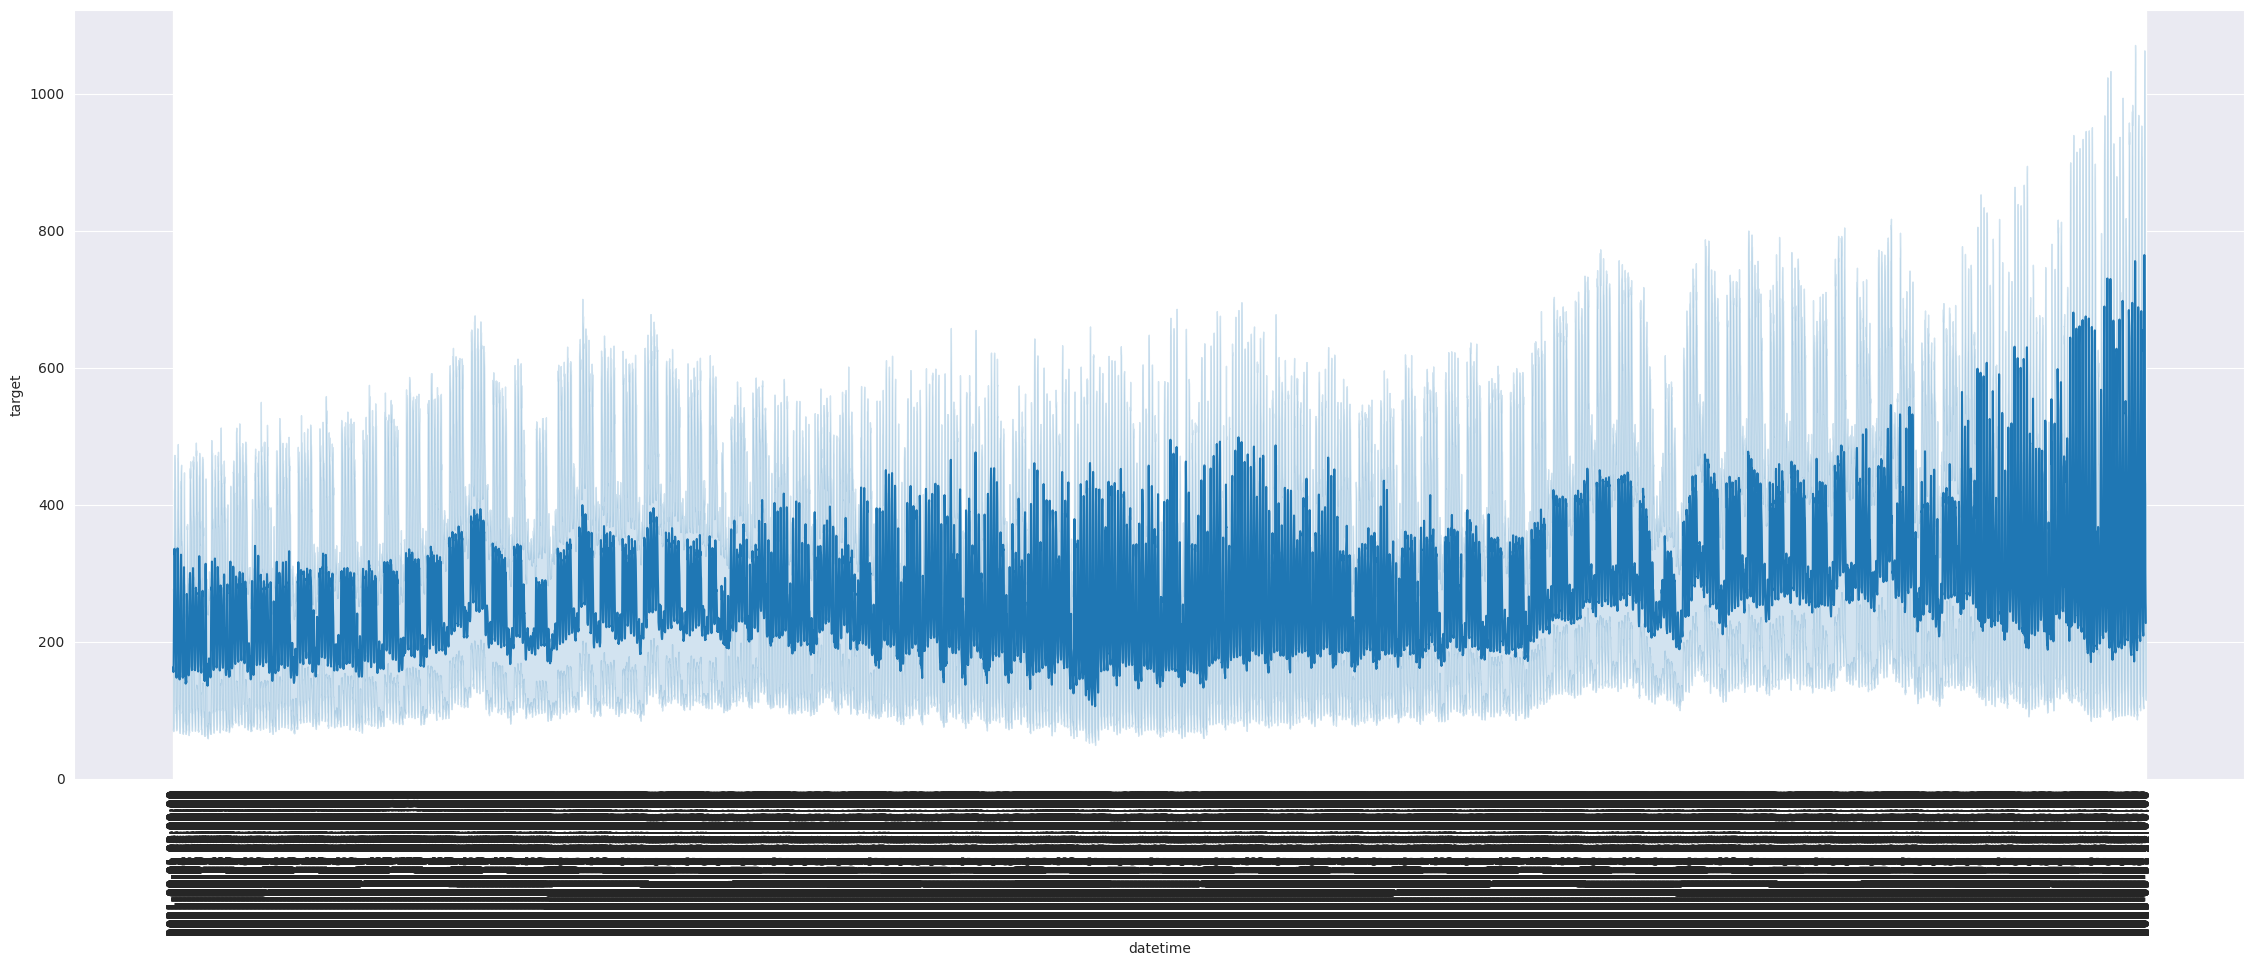

In [151]:
plt.figure(figsize=(28, 10))
plt.xticks(rotation=90)
sns.lineplot(x="datetime", y="target", data=df)

<Axes: xlabel='datetime', ylabel='target'>

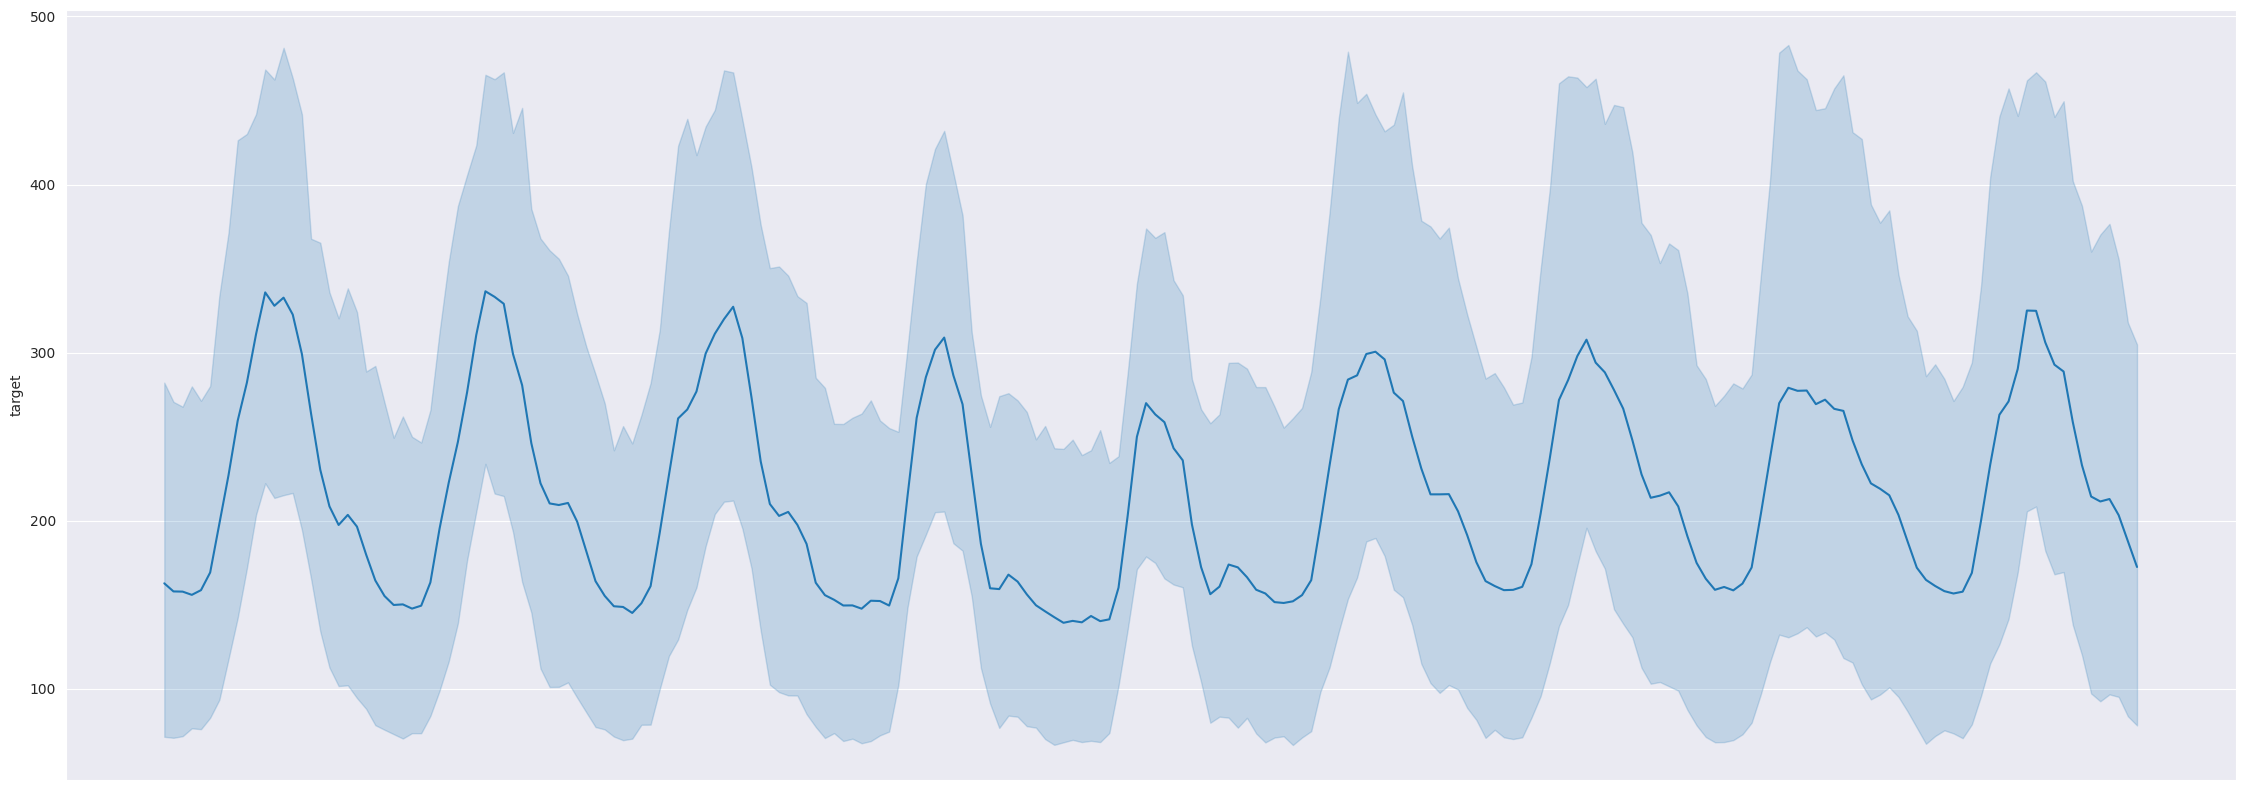

In [152]:
plt.figure(figsize=(28, 10))
# remove xticks
plt.xticks([])
sns.lineplot(x="datetime", y="target", data=df[(df["datetime"] >= "2021-09-01") & (df["datetime"] <= "2021-09-10")])

In [153]:
df["datetime"]

0          2021-09-01 00:00:00
1          2021-09-01 00:00:00
2          2021-09-01 00:00:00
3          2021-09-01 00:00:00
4          2021-09-01 00:00:00
                  ...         
2018347    2023-05-31 23:00:00
2018348    2023-05-31 23:00:00
2018349    2023-05-31 23:00:00
2018350    2023-05-31 23:00:00
2018351    2023-05-31 23:00:00
Name: datetime, Length: 2017824, dtype: object

In [154]:
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")

In [155]:
consumption_df = df[df["is_consumption"] == 1]
consumption_df.head()

county  is_business  product_type   target  is_consumption   datetime  \
1       0            0             1   96.590               1 2021-09-01   
3       0            0             2   17.314               1 2021-09-01   
5       0            0             3  656.859               1 2021-09-01   
7       0            1             0   59.000               1 2021-09-01   
9       0            1             1  501.760               1 2021-09-01   

   data_block_id  prediction_unit_id  
1              0                   0  
3              0                   1  
5              0                   2  
7              0                   3  
9              0                   4

In [156]:
production_df = df[df["is_consumption"] == 0]
production_df.head()

county  is_business  product_type  target  is_consumption   datetime  \
0       0            0             1   0.713               0 2021-09-01   
2       0            0             2   0.000               0 2021-09-01   
4       0            0             3   2.904               0 2021-09-01   
6       0            1             0   0.000               0 2021-09-01   
8       0            1             1   0.000               0 2021-09-01   

   data_block_id  prediction_unit_id  
0              0                   0  
2              0                   1  
4              0                   2  
6              0                   3  
8              0                   4

In [157]:
consumption_df_resample = consumption_df[["datetime", "target"]].resample(f'3H', on='datetime').mean().reset_index()
consumption_df_resample.head()

datetime      target
0 2021-09-01 00:00:00  319.047967
1 2021-09-01 03:00:00  322.600858
2 2021-09-01 06:00:00  424.375049
3 2021-09-01 09:00:00  349.193951
4 2021-09-01 12:00:00  317.744087

In [158]:
production_df_resample = production_df[["datetime", "target"]].resample(f'3H', on='datetime').mean().reset_index()
production_df_resample.head()

datetime      target
0 2021-09-01 00:00:00    0.098683
1 2021-09-01 03:00:00    0.069322
2 2021-09-01 06:00:00   32.136066
3 2021-09-01 09:00:00  270.114678
4 2021-09-01 12:00:00  337.798443

In [159]:
consumption_df_resample["is_consumption"] = 1
production_df_resample["is_consumption"] = 0

In [160]:
new_df = pd.concat([consumption_df_resample, production_df_resample])
new_df = new_df.sort_values(by="datetime")
new_df

datetime      target  is_consumption
0    2021-09-01 00:00:00  319.047967               1
0    2021-09-01 00:00:00    0.098683               0
1    2021-09-01 03:00:00    0.069322               0
1    2021-09-01 03:00:00  322.600858               1
2    2021-09-01 06:00:00  424.375049               1
...                  ...         ...             ...
5101 2023-05-31 15:00:00  349.067677               1
5102 2023-05-31 18:00:00  194.402421               0
5102 2023-05-31 18:00:00  432.957538               1
5103 2023-05-31 21:00:00  480.731421               1
5103 2023-05-31 21:00:00    7.705979               0

[10208 rows x 3 columns]

<Axes: xlabel='datetime', ylabel='target'>

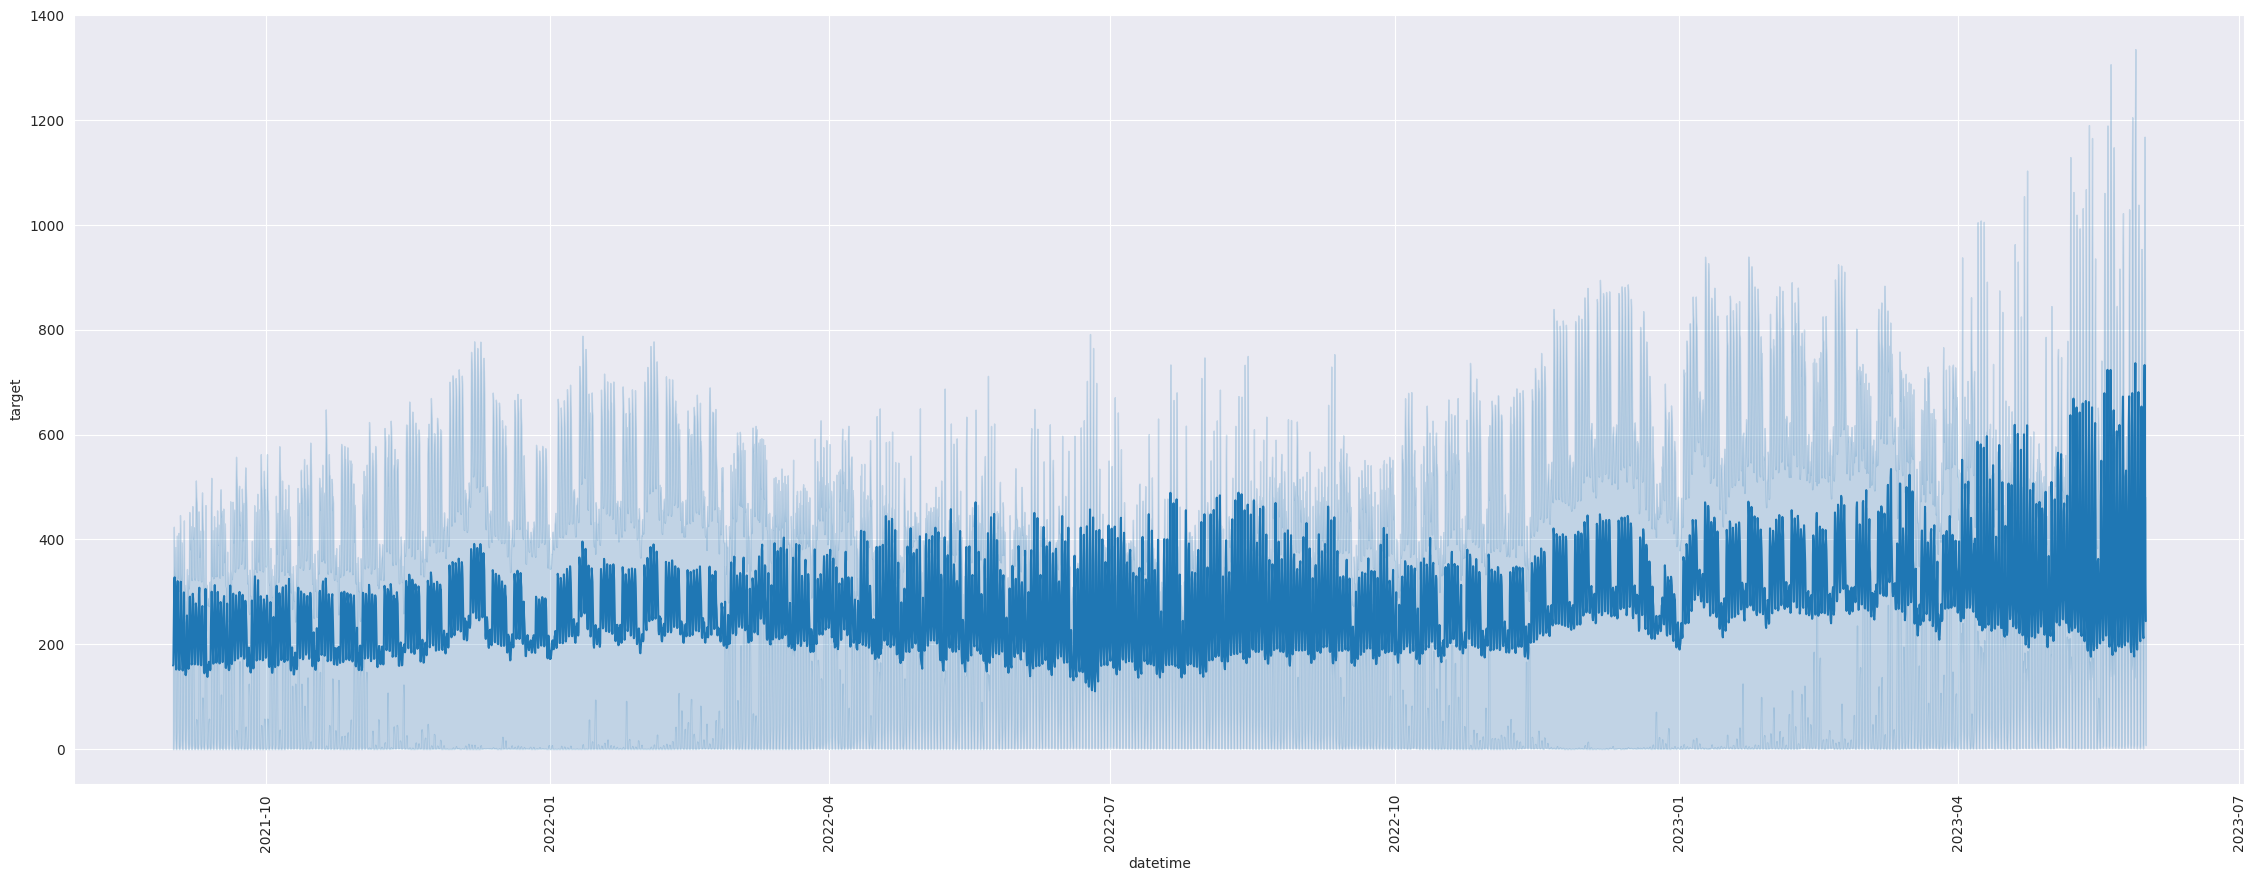

In [161]:
plt.figure(figsize=(28, 10))
plt.xticks(rotation=90)
sns.lineplot(x="datetime", y="target", data=new_df)

<Axes: xlabel='datetime', ylabel='target'>

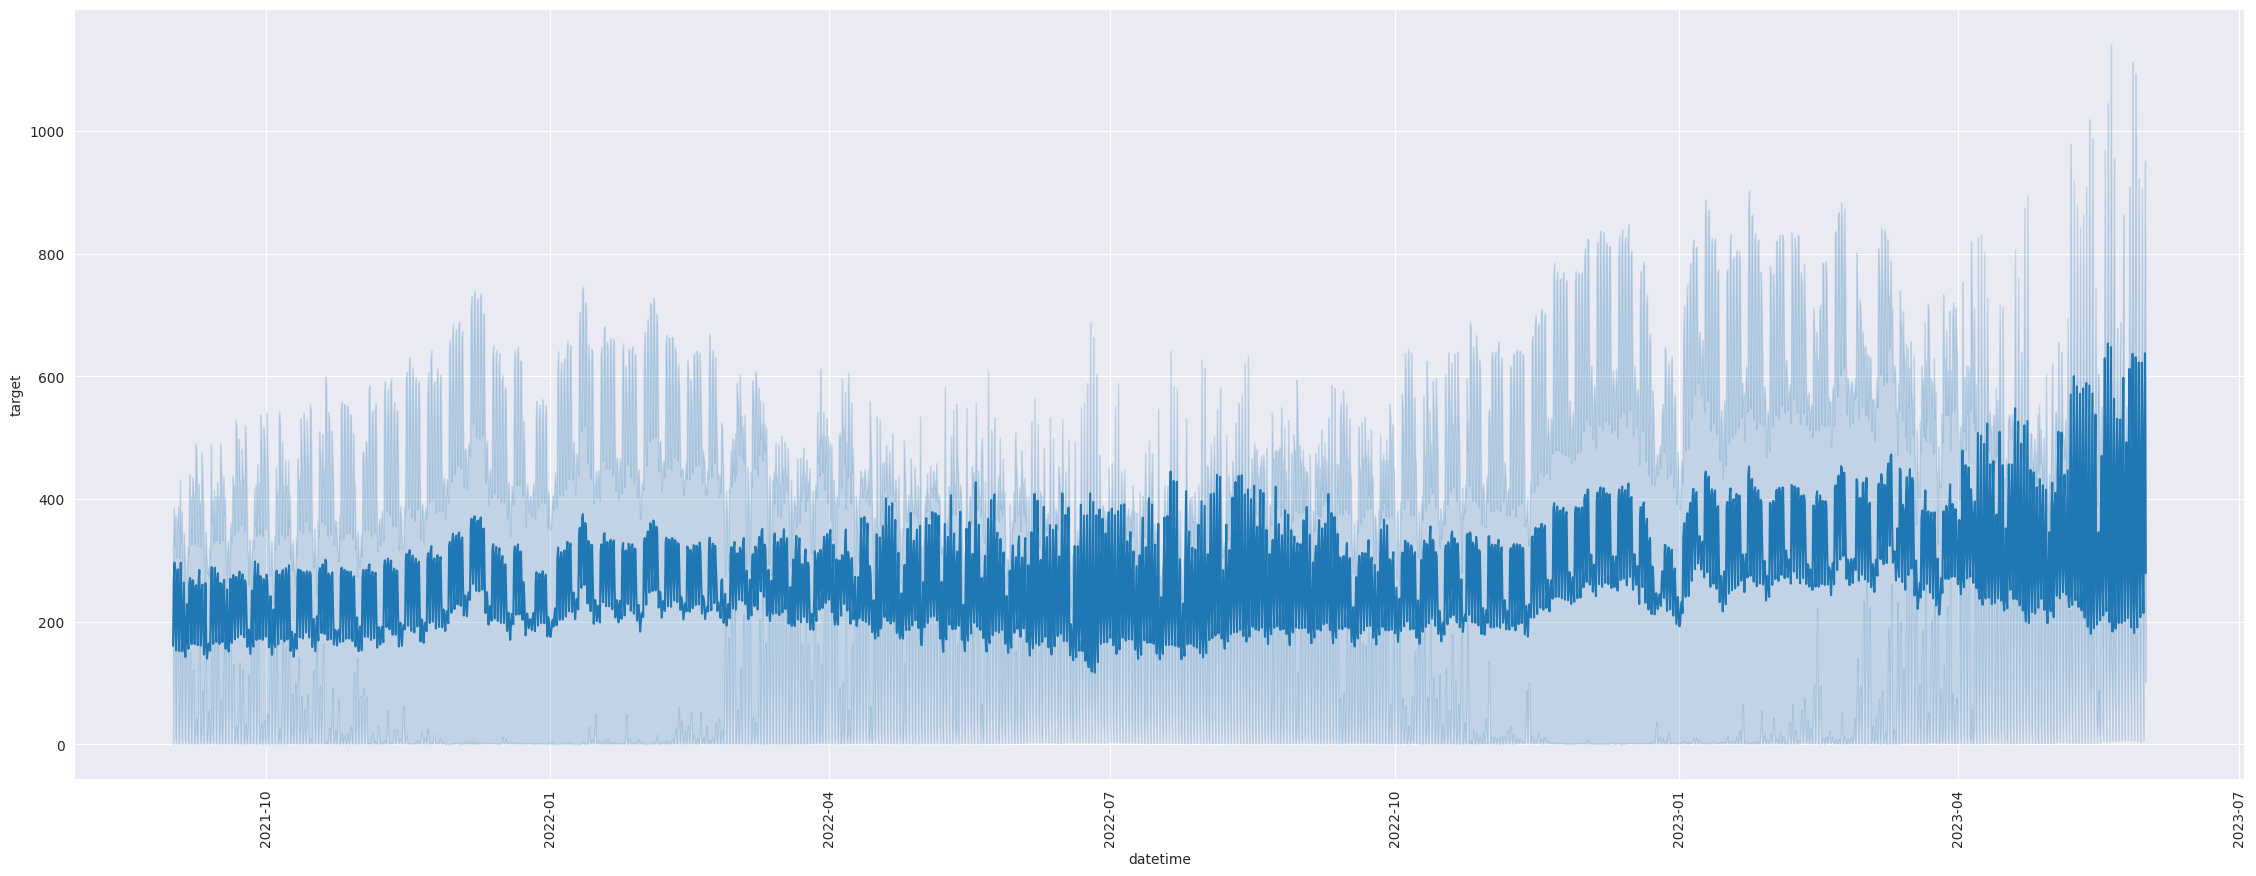

In [162]:
consumption_df_resample = consumption_df[["datetime", "target"]].resample(f'6H', on='datetime').mean().reset_index()
production_df_resample = production_df[["datetime", "target"]].resample(f'6H', on='datetime').mean().reset_index()
consumption_df_resample["is_consumption"] = 1
production_df_resample["is_consumption"] = 0
new_df = pd.concat([consumption_df_resample, production_df_resample])
new_df = new_df.sort_values(by="datetime")
plt.figure(figsize=(28, 10))
plt.xticks(rotation=90)
sns.lineplot(x="datetime", y="target", data=new_df)

<Axes: xlabel='datetime', ylabel='target'>

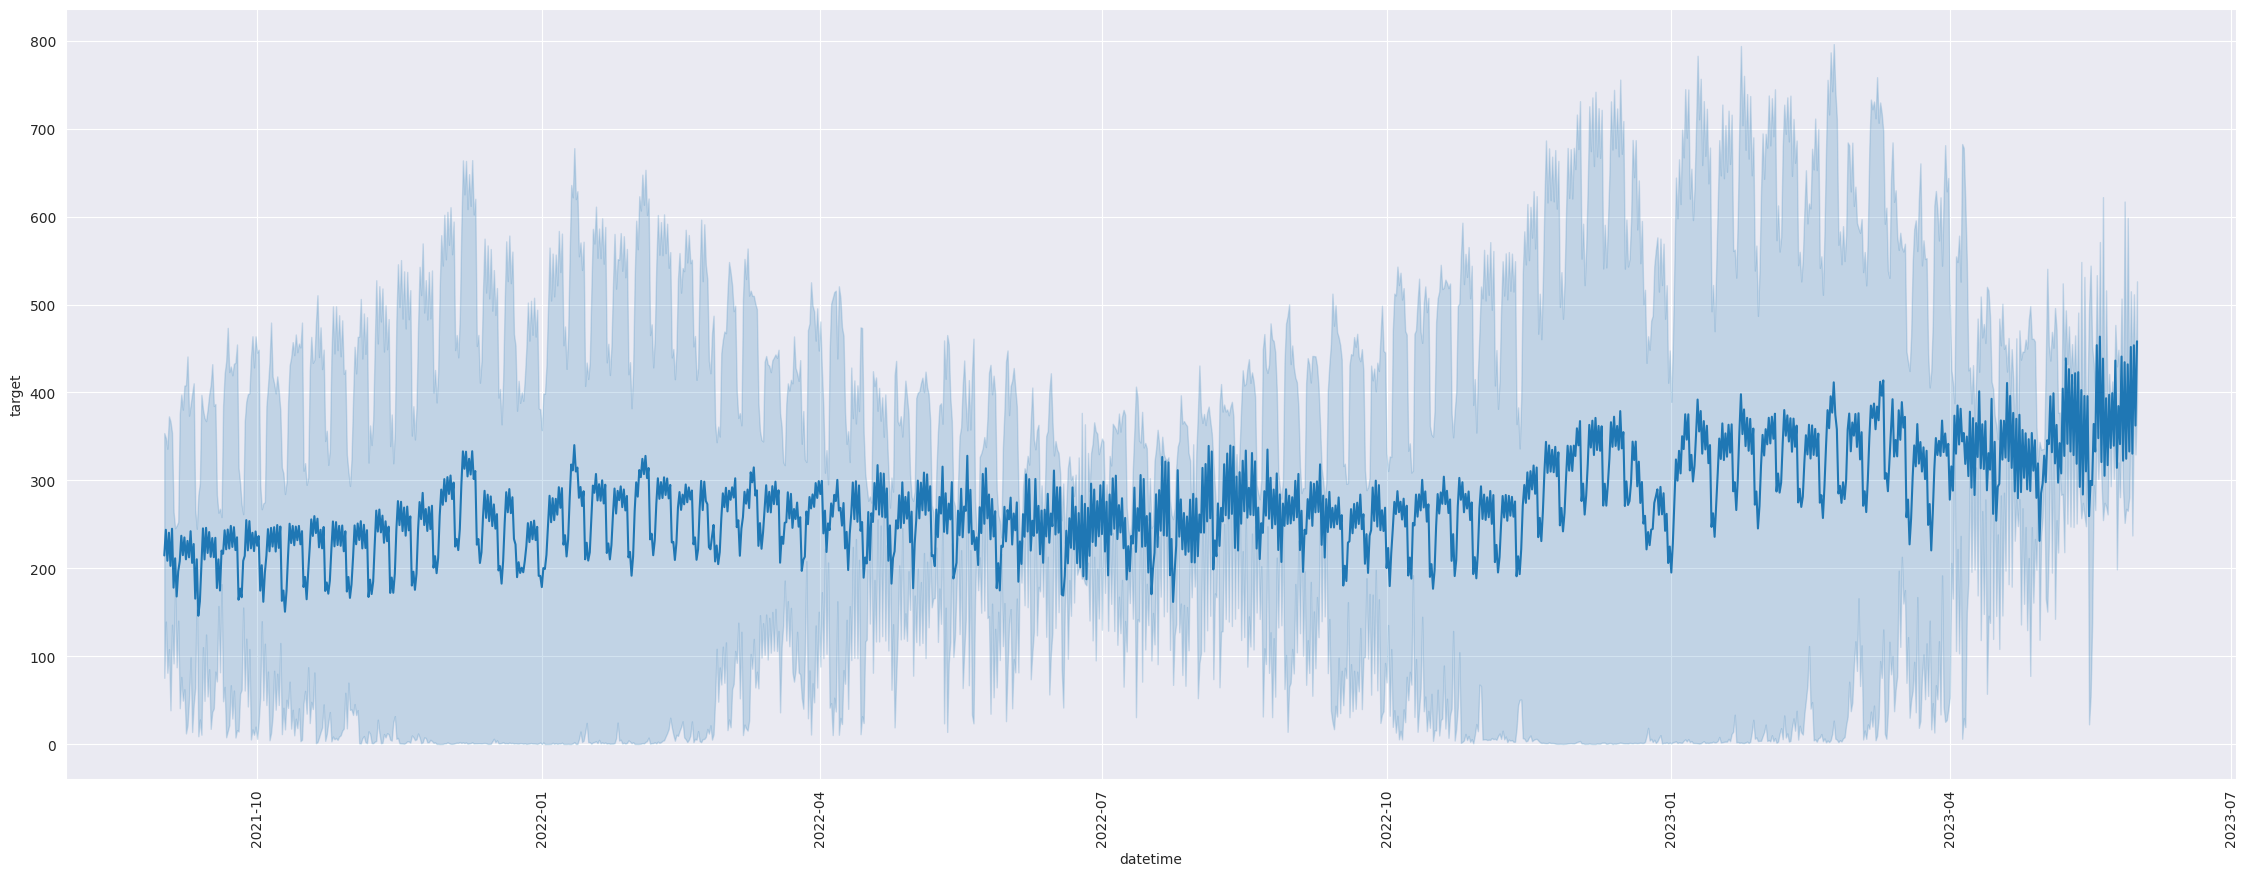

In [163]:
consumption_df_resample = consumption_df[["datetime", "target"]].resample(f'12H', on='datetime').mean().reset_index()
production_df_resample = production_df[["datetime", "target"]].resample(f'12H', on='datetime').mean().reset_index()
consumption_df_resample["is_consumption"] = 1
production_df_resample["is_consumption"] = 0
new_df = pd.concat([consumption_df_resample, production_df_resample])
new_df = new_df.sort_values(by="datetime")
plt.figure(figsize=(28, 10))
plt.xticks(rotation=90)
sns.lineplot(x="datetime", y="target", data=new_df)

<Axes: xlabel='datetime', ylabel='target'>

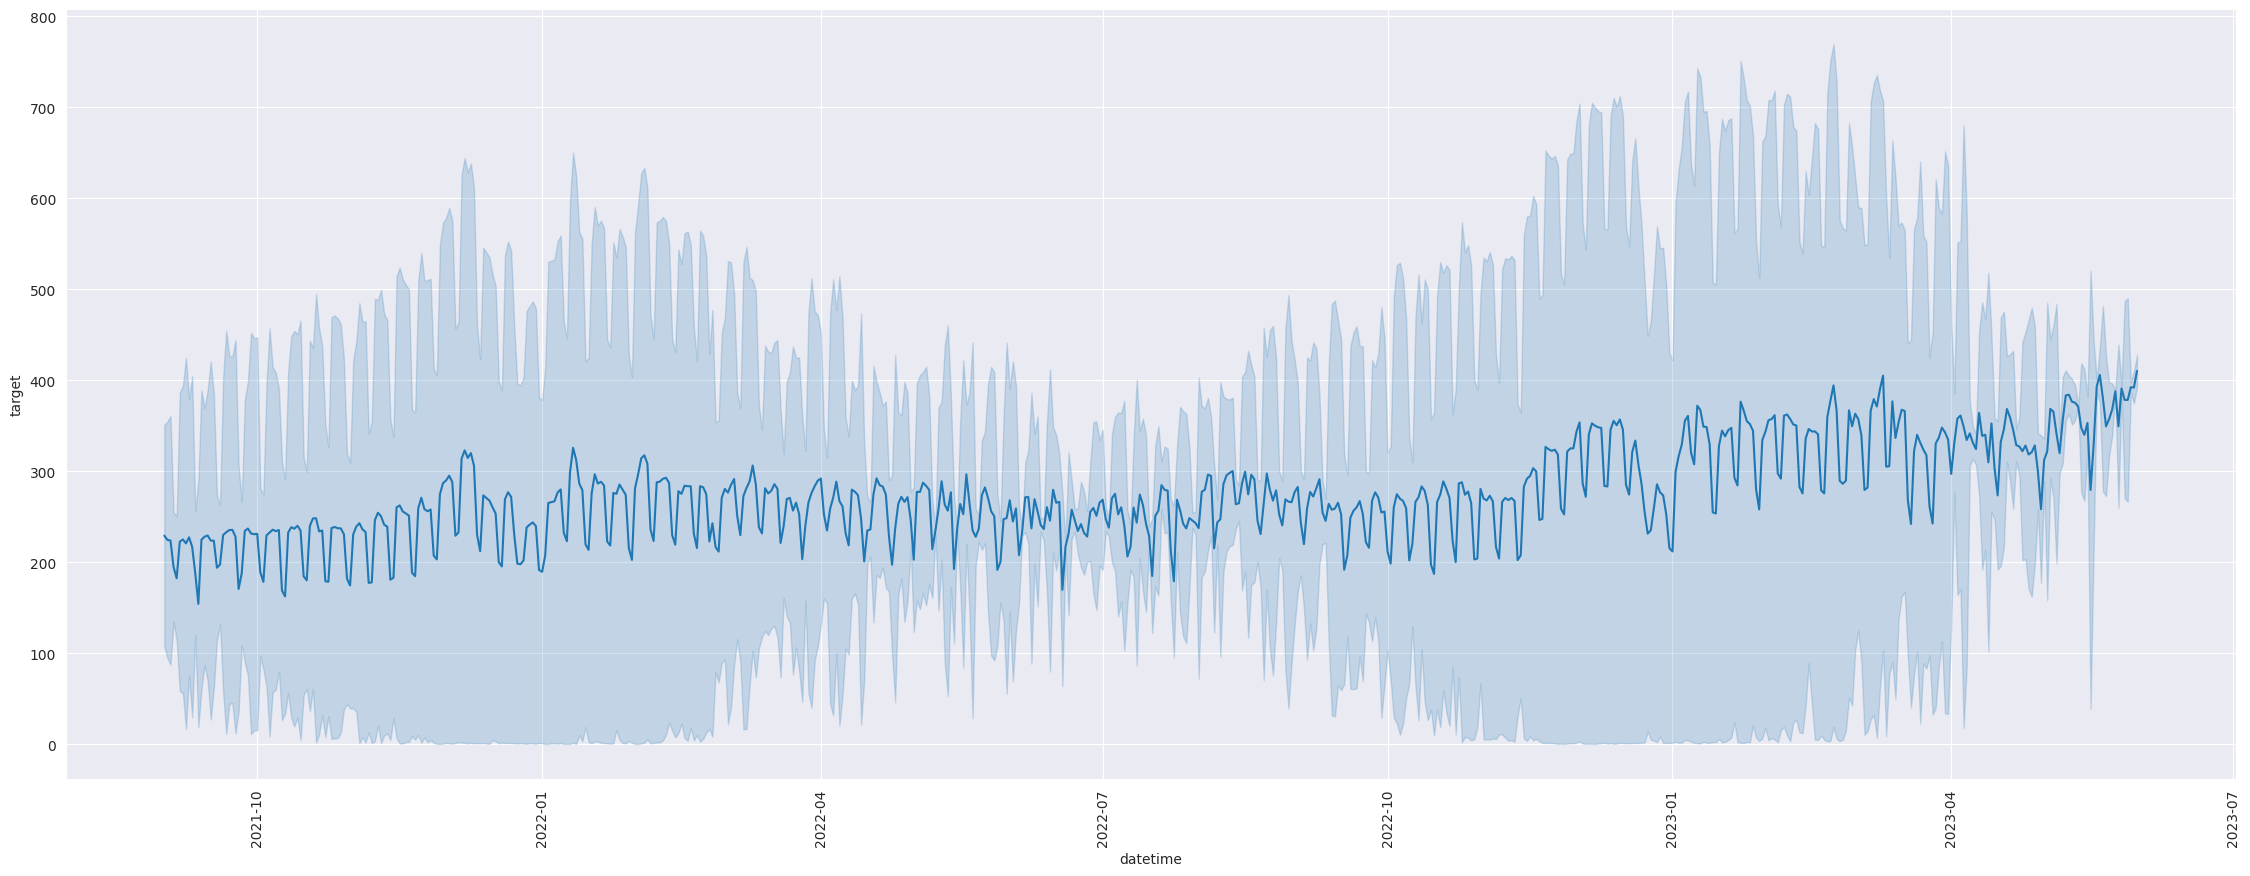

In [164]:
consumption_df_resample = consumption_df[["datetime", "target"]].resample(f'24H', on='datetime').mean().reset_index()
production_df_resample = production_df[["datetime", "target"]].resample(f'24H', on='datetime').mean().reset_index()
consumption_df_resample["is_consumption"] = 1
production_df_resample["is_consumption"] = 0
new_df = pd.concat([consumption_df_resample, production_df_resample])
new_df = new_df.sort_values(by="datetime")
plt.figure(figsize=(28, 10))
plt.xticks(rotation=90)
sns.lineplot(x="datetime", y="target", data=new_df)

<Axes: xlabel='datetime', ylabel='target'>

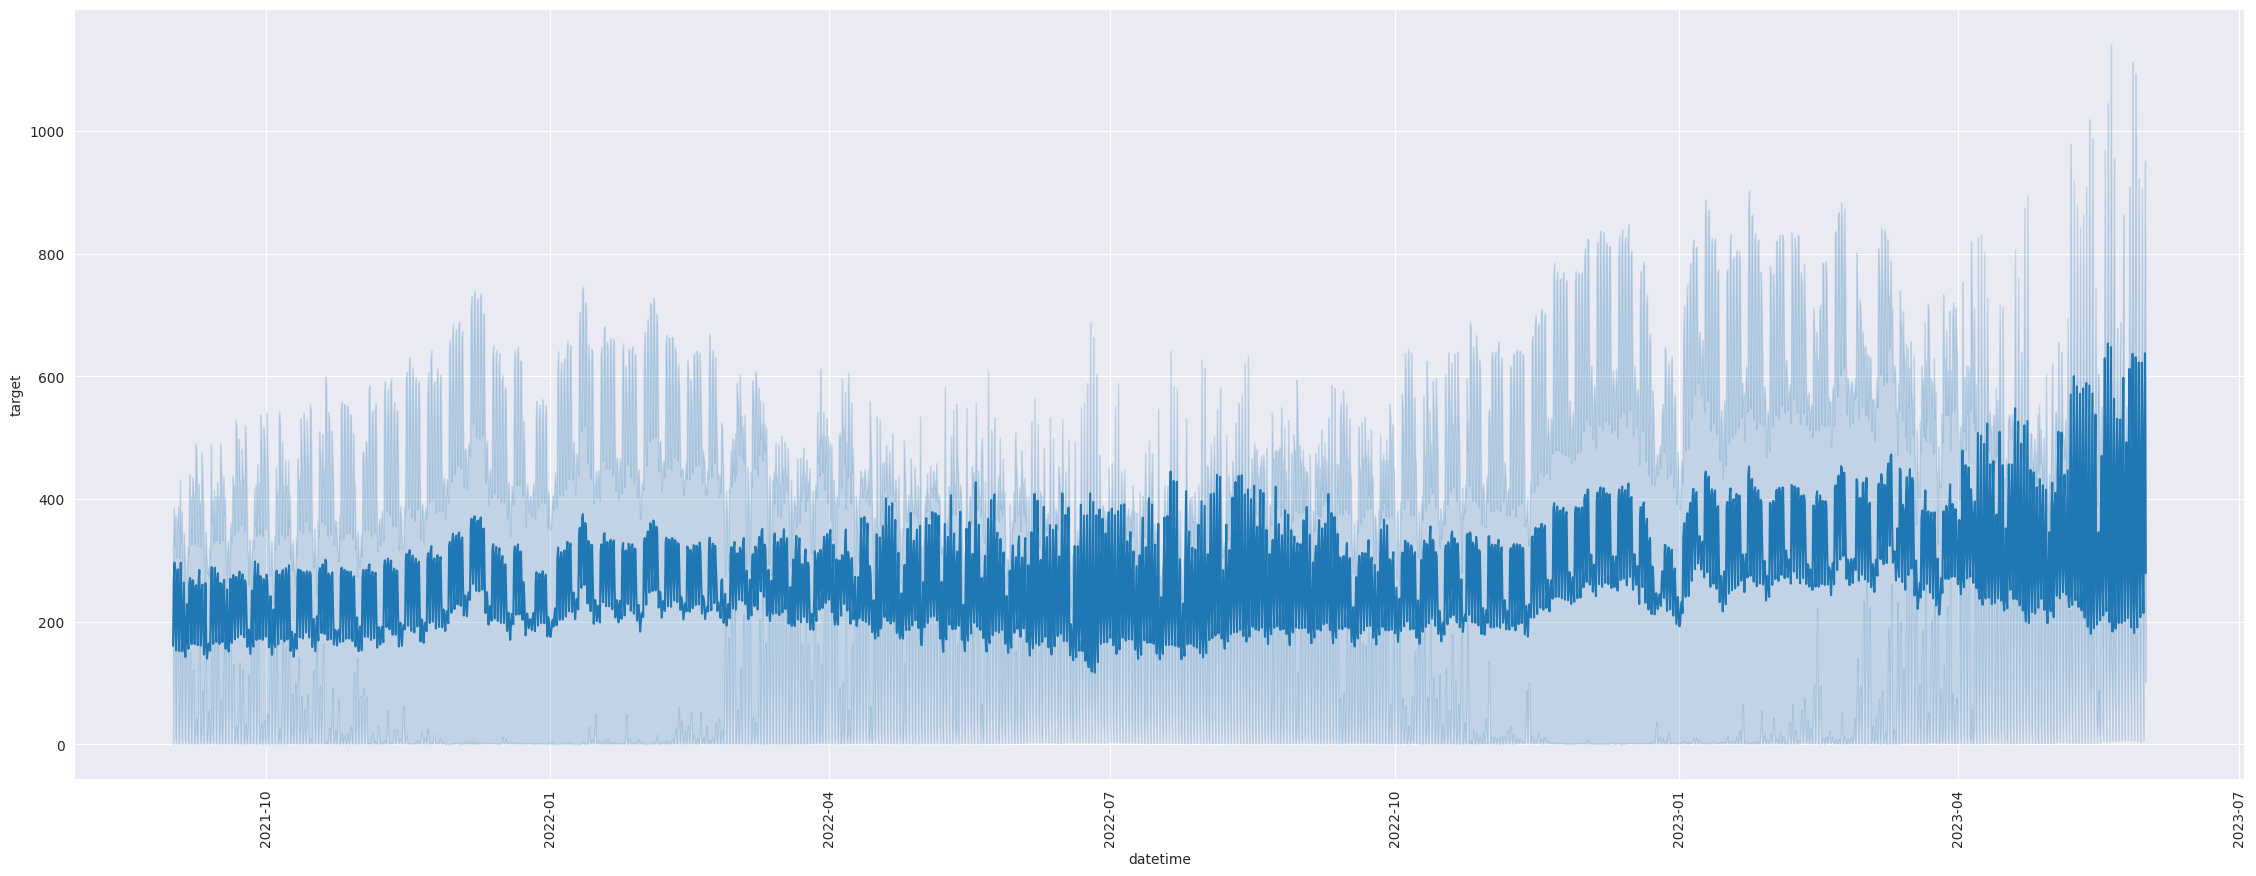

In [165]:
consumption_df_resample = consumption_df[["datetime", "target"]].resample(f'6H', on='datetime').mean().reset_index()
production_df_resample = production_df[["datetime", "target"]].resample(f'6H', on='datetime').mean().reset_index()
consumption_df_resample["is_consumption"] = 1
production_df_resample["is_consumption"] = 0
new_df = pd.concat([consumption_df_resample, production_df_resample])
new_df = new_df.sort_values(by="datetime")
plt.figure(figsize=(28, 10))
plt.xticks(rotation=90)
sns.lineplot(x="datetime", y="target", data=new_df)

<Axes: xlabel='datetime', ylabel='target'>

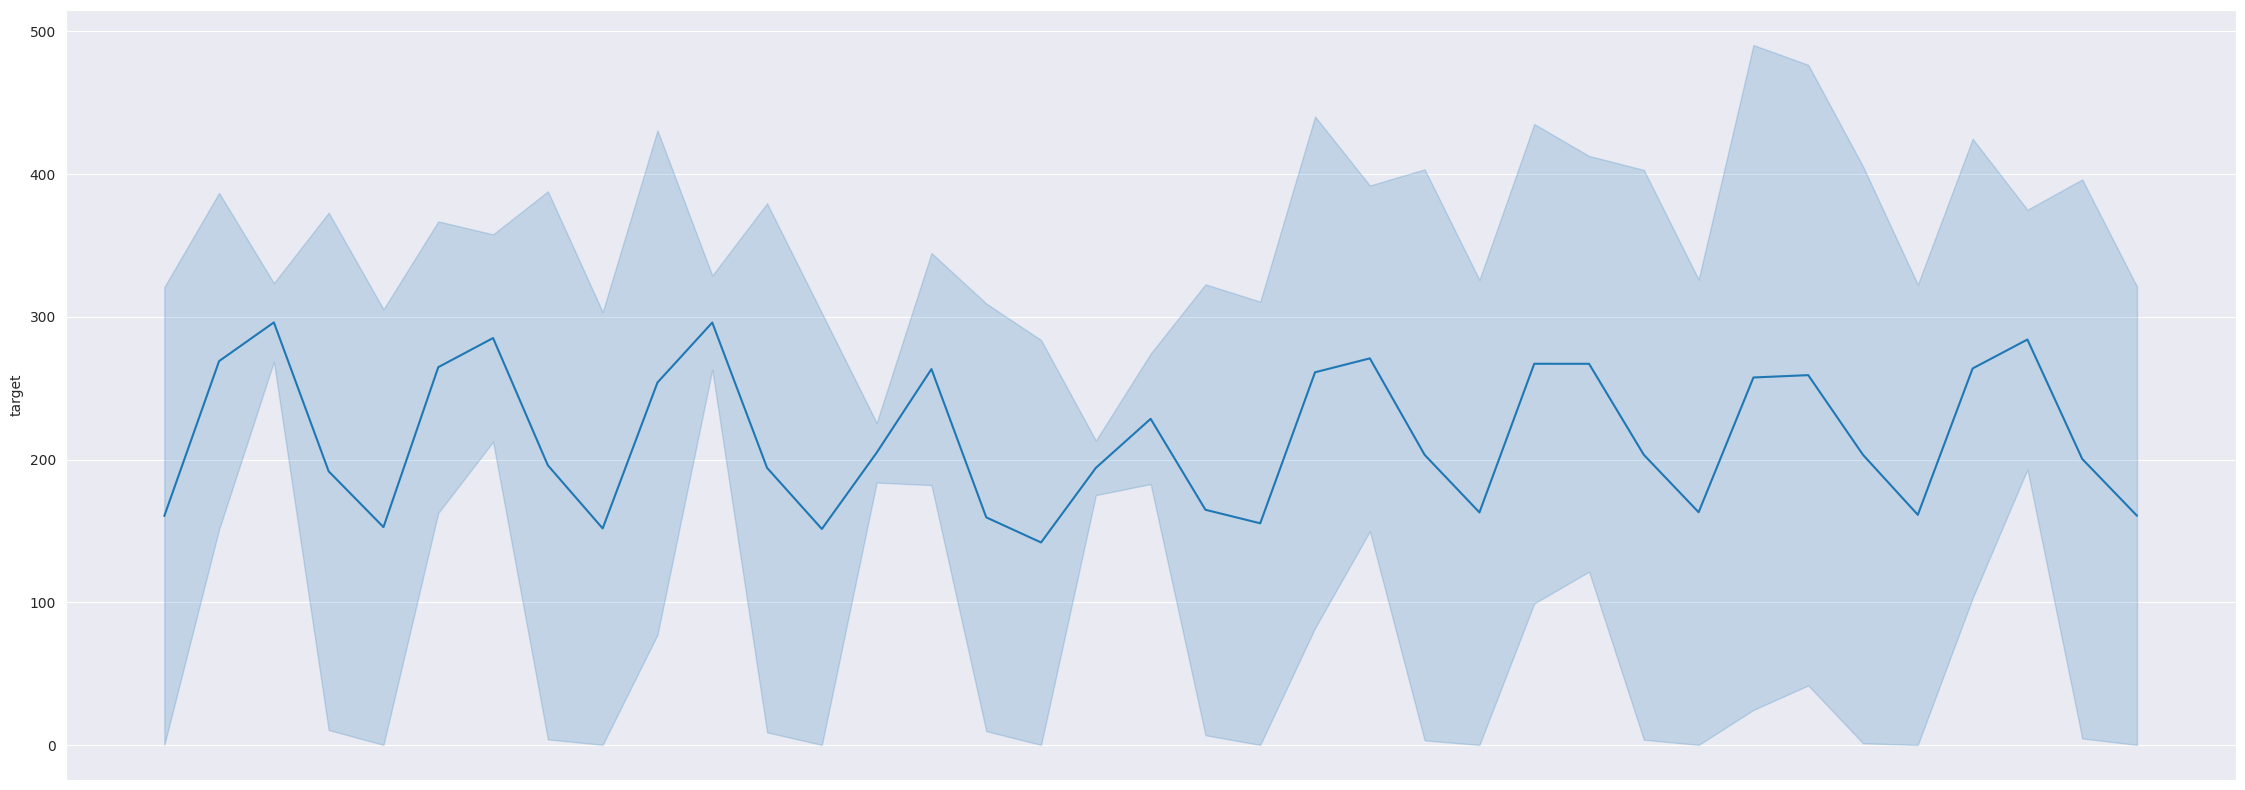

In [166]:
plt.figure(figsize=(28, 10))
plt.xticks([])
sns.lineplot(x="datetime", y="target", data=new_df[(new_df["datetime"] >= "2021-09-01") & (new_df["datetime"] <= "2021-09-10")])

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [168]:
def plot_decomposition(new_df, periodo: int):
    decomposition = seasonal_decompose(new_df["target"], model='additive', period=periodo)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotando as componentes
    plt.figure(figsize=(20, 8))

    plt.subplot(411)
    plt.plot(new_df["target"], label='Original')
    plt.legend(loc='best')
    plt.title('Série Temporal Original')

    plt.subplot(412)
    plt.plot(trend, label='Tendência')
    plt.legend(loc='best')
    plt.title('Tendência')

    plt.subplot(413)
    plt.plot(seasonal, label='Sazonalidade')
    plt.legend(loc='best')
    plt.title('Sazonalidade')

    plt.subplot(414)
    plt.plot(residual, label='Ruído')
    plt.legend(loc='best')
    plt.title('Ruído')

    plt.tight_layout()
    plt.show()

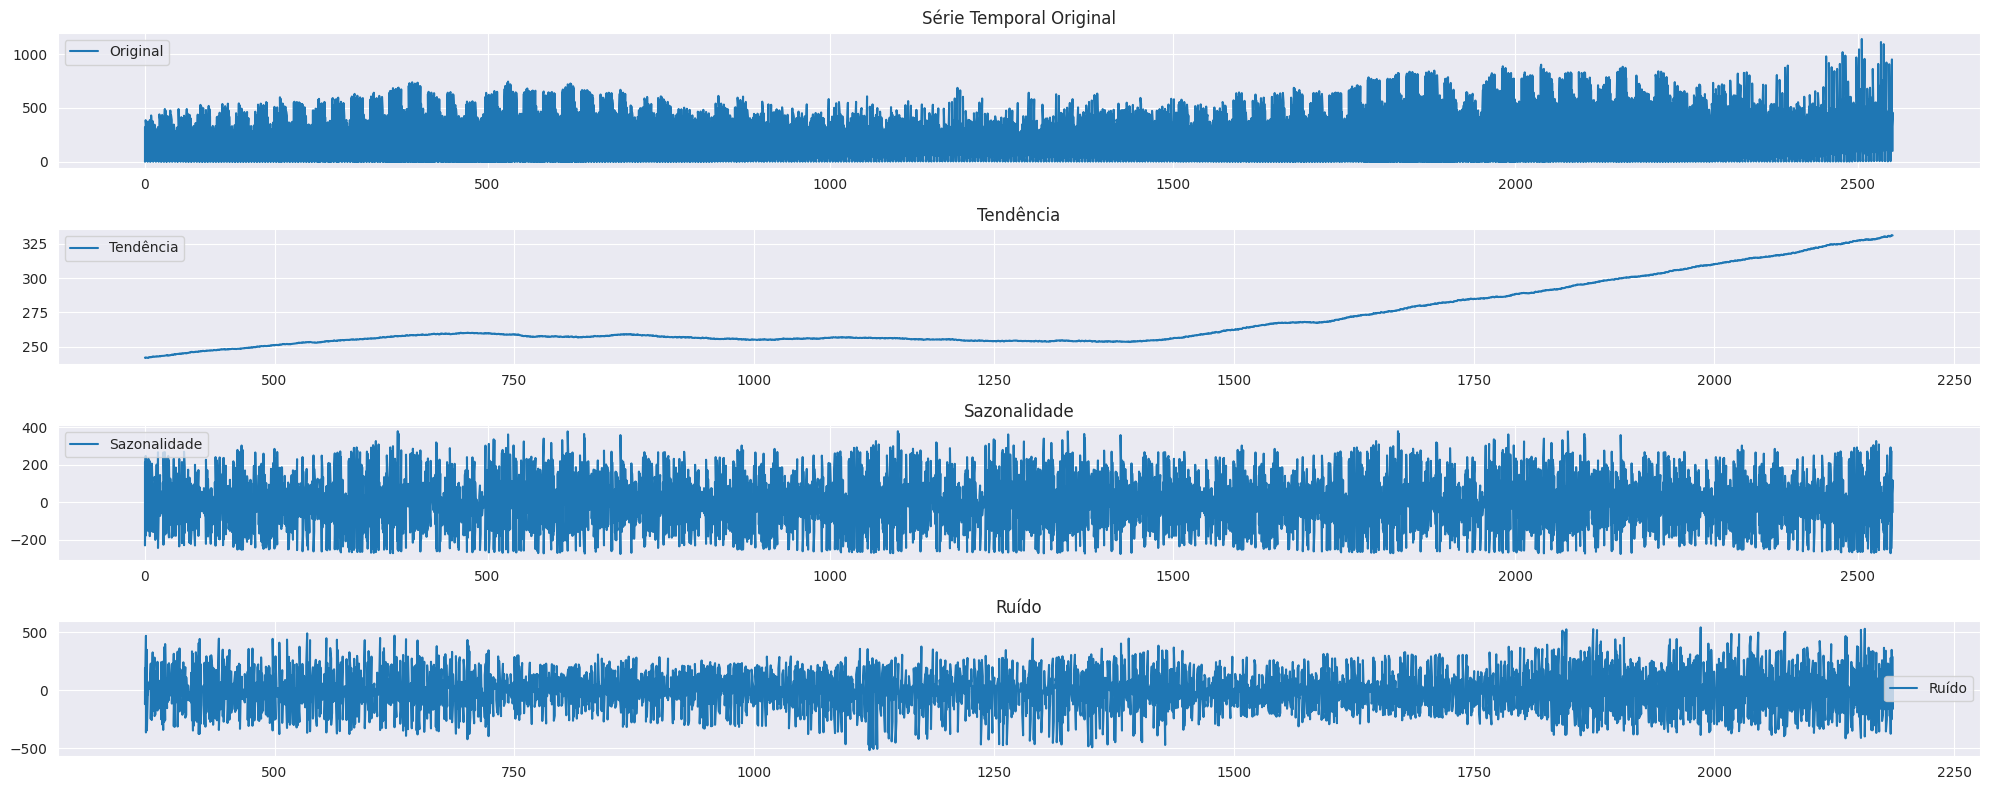

In [169]:
plot_decomposition(new_df=new_df, periodo=int((24 / 3) * (365 / 2))) # 6 meses

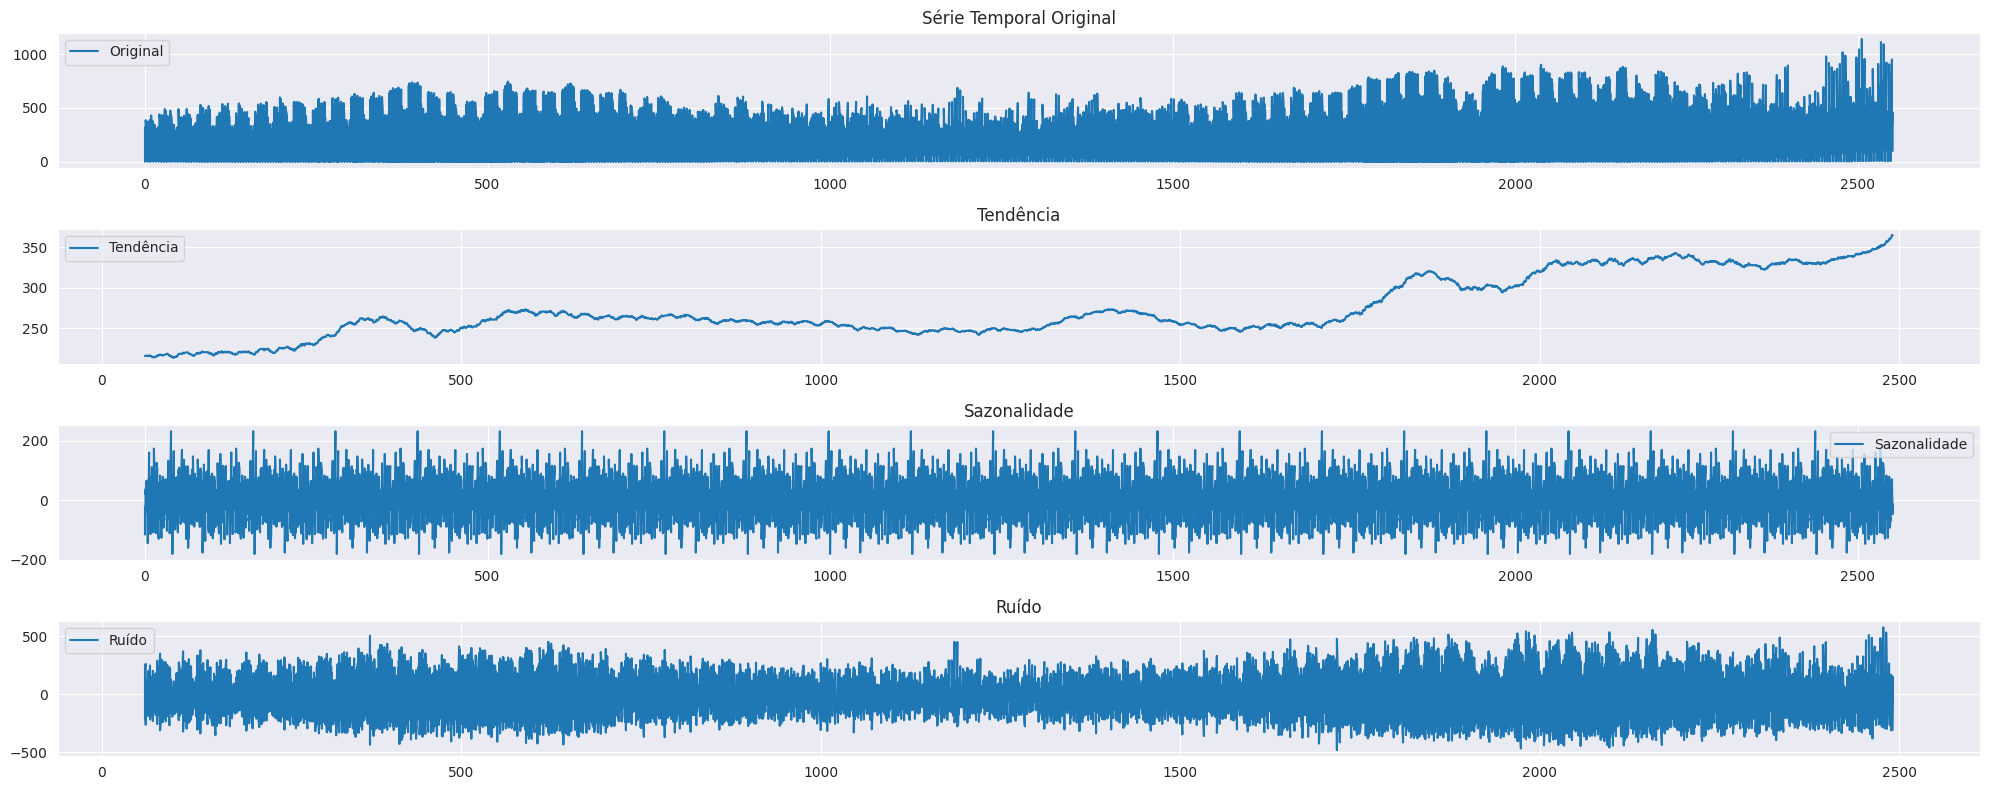

In [170]:
plot_decomposition(new_df=new_df, periodo=int(30 * (24 / 3))) # 1 mês

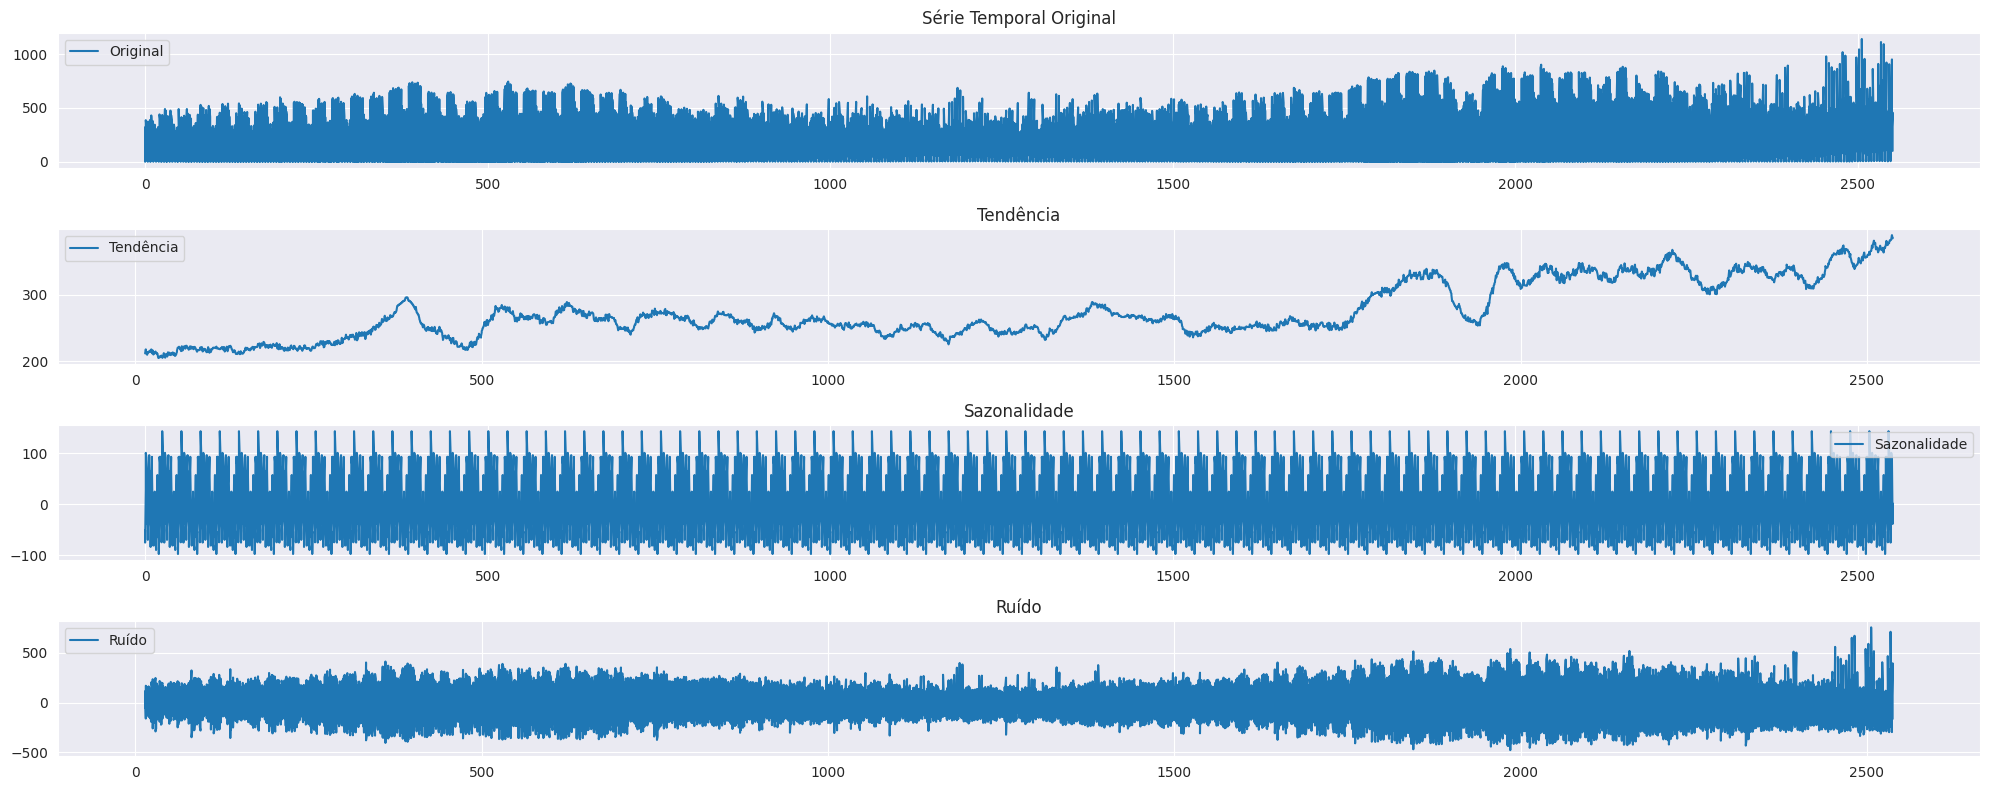

In [171]:
plot_decomposition(new_df=new_df, periodo=int(7 * (24 / 3))) # 1 semana

In [172]:
train_df = new_df[:int(len(new_df) * 0.8)]
test_df = new_df[int(len(new_df) * 0.8):]

In [173]:
from sktime.forecasting.compose import make_reduction

# árvore de decisão
from sklearn.tree import DecisionTreeRegressor
# KNN
from sklearn.neighbors import KNeighborsRegressor
# MLP
from sklearn.neural_network import MLPRegressor
# SVR
from sklearn.svm import SVR
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

In [174]:
# MSE
from sklearn.metrics import mean_squared_error
# MAE
from sklearn.metrics import mean_absolute_error

In [181]:
train_df.index = pd.RangeIndex(len(train_df.index))
# test_df.index = pd.RangeIndex(len(test_df.index))

In [183]:
mse = rmse = mae = []
models = [
    DecisionTreeRegressor(criterion="squared_error", max_depth=20), DecisionTreeRegressor(criterion="absolute_error", max_depth=40),
    KNeighborsRegressor(n_neighbors=5, metric="minkowski"), KNeighborsRegressor(n_neighbors=10, metric="precomputed"),
    MLPRegressor(learning_rate="constant", batch_size=100, activation="relu"), MLPRegressor(learning_rate="adaptive", batch_size=200, activation="logistic"),
    SVR(kernel="linear", C=1.0, gamma="auto"), SVR(kernel="sigmoid", C=2.0, gamma="scale"),
    RandomForestRegressor(random_state=42, max_depth=20, criterion="poisson"), GradientBoostingRegressor(criterion="squared_error", max_depth=20)
]
for model in models:
    mse_temp = rmse_temp = mae_temp = []
    try:
        for _ in range(10):
            model_ = make_reduction(
                model,
                window_length=10 * 4,
                strategy="recursive"
            )
            model_.fit(train_df["target"])
            y_pred = model_.predict(np.arange(1, len(test_df) + 1))
            mse_temp.append(mean_squared_error(test_df["target"], y_pred))
            rmse_temp.append(mean_squared_error(test_df["target"], y_pred, squared=False))
            mae_temp.append(mean_absolute_error(test_df["target"], y_pred))
    except:
        mse_temp.append(0)
        rmse_temp.append(0)
        mae_temp.append(0)

    mse.append(np.mean(mse_temp))
    rmse.append(np.mean(rmse_temp))
    mae.append(np.mean(mae_temp))

/home/jhonatan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhonatan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhonatan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhonatan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhonatan/.local/lib/python3.10/sit